In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] ='nearest'
plt.rcParams['font.size'] = 14
import matplotlib.patches as patches
import math
import time
import scipy.special as special

import sys
import os
sys.path.append(os.pardir)
from wave_func import *
from sf_util import *

## Preparation

In [2]:
# Config
c = 340.29  # sound speed
freq = 1000  # frequency for narrowband
f_target = np.arange(100,1501,100)  # target frequency for broadband
fbin = np.arange(100,2001,100)  # frequency bin for broadband
L = 10  # number of selection

# Simulation field
x_lim = [-2,2]
y_lim = [-2,2]
dx = 0.01
dy = 0.01
xticks = np.arange(x_lim[0], x_lim[1]+1e-4, dx)
yticks = np.arange(y_lim[0], y_lim[1]+1e-4, dy)
X, Y = np.meshgrid(xticks, yticks)

In [3]:
# Candidate position
posSrc = np.load("posCandidate.npy")

# Reproduction area
radi = 0.5  # radi
cent = [0.0,0.3,0]  # center

# Evaluation point
posEval = []
for i, x in enumerate(xticks):
    for j, y in enumerate(yticks):
        if (x-cent[0])**2 + (y-cent[1])**2 <= radi**2:
            posEval.append([x,y,0])
posEval = np.array(posEval)

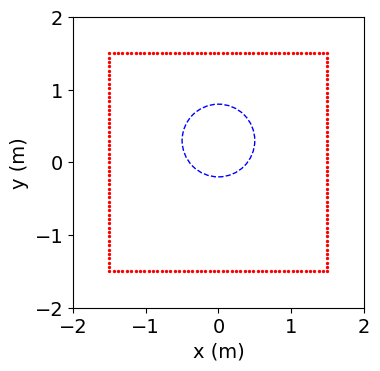

In [4]:
# Plot field
# 2D
fig, ax = plt.subplots(figsize=(4,4))
ax.grid(False)
ax.scatter(posSrc[:,0],posSrc[:,1], s=10, linewidth=0.8, marker='.', c="r", label="src")
ax.set_aspect('equal')
obj_zone = patches.Circle(xy=cent, radius=radi, ec="b", fill=False, ls='dashed')
ax.add_patch(obj_zone)

ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
plt.xticks(np.arange(xticks[0],xticks[-1],1))
plt.yticks(np.arange(yticks[0],yticks[-1],1))

plt.tight_layout()

# plt.savefig("figs/field2D.png")
plt.show()

## Narrowband

Truncation order :  19


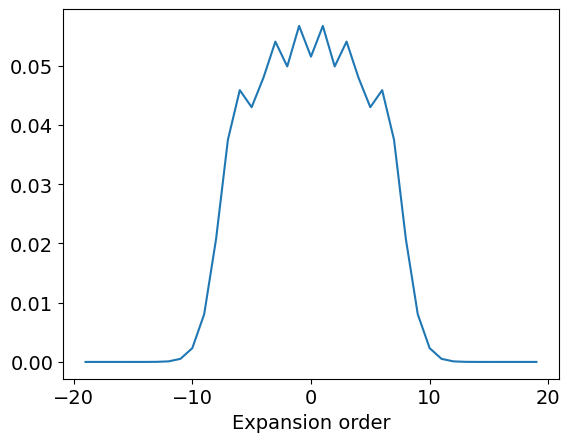

In [5]:
# Wave number
k = 2*np.pi*freq/c

# Weight matrix
N = math.ceil(2*k*radi)  # >> k*radi
print("Truncation order : ", N)

W = np.zeros((2*N+1,2*N+1), dtype=complex)
for n in range(-N, N+1):
    idx = n+N
    W[idx][idx] = np.pi * radi**2 * (special.jv(n, k*radi)**2 - special.jv(n+1, k*radi)*special.jv(n-1, k*radi))    

plt.plot(range(-N, N+1), np.diag(W.real))
plt.xlabel("Expansion order")
plt.show()

In [6]:
# Transfer function matrix for WMM
G_mm = np.zeros((2*N+1,len(posSrc)), dtype=complex)
for i in range(len(posSrc)):
    G_mm[:, i] += cylindricalwave_coef(cent[:2], posSrc[i][:2], k, N)

1 selected： 180
2 selected： 168
3 selected： 192
4 selected： 162
5 selected： 199
6 selected： 185
7 selected： 152
8 selected： 8
9 selected： 174
10 selected： 14


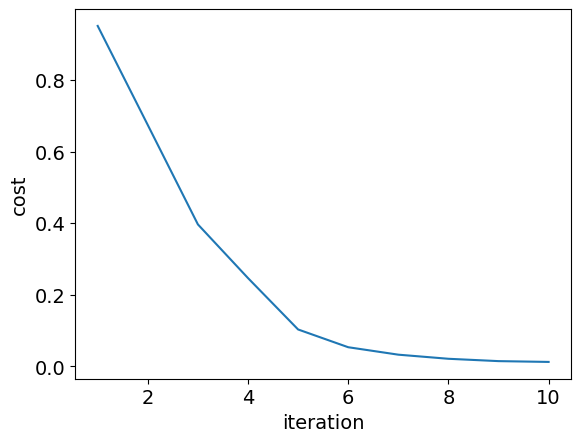

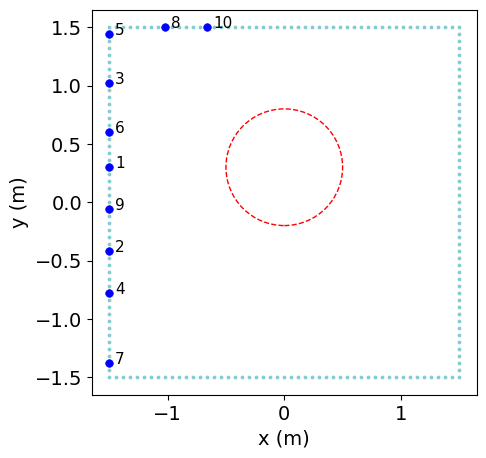

In [7]:
# Source optimization

G = G_mm

# Prior information
Sig = np.zeros((2*N+1,2*N+1), dtype=complex)
mu = np.zeros(2*N+1, dtype=complex)
for i in range(-N,N+1):
    for j in range(-N,N+1):
        if i != j:
            Sig[j+N,i+N] = 1j**(i-j)/(1j*(i-j))*(np.exp(1j*(i-j)*np.pi/4)-np.exp(-1j*(i-j)*np.pi/4))
        else:
            Sig[j+N,i+N] = np.pi/2

# Cost function
def cost_func(srcIdx, G, Sig, mu, reg=1e-3, W=None):
    if W is None:
        W = np.diag(np.ones(len(G)))
    Phi = np.zeros((len(G[0]),len(srcIdx)))
    for s,idx in enumerate(srcIdx):
        Phi[idx,s] = 1
    A = np.linalg.inv(Phi.T @ G.conj().T @ W @ G @ Phi + reg * np.eye(len(srcIdx)))
    D = W - W@G@Phi@A@Phi.T@G.conj().T@W.T
    cost = np.trace(D@Sig)+mu.conj().T@D@mu
    return cost.real
    
# Greedy algorithm

select = []
unselect = list(range(len(posSrc)))
costs = []

lmd = 1e-5

while len(select) < L:
    minval = 1e6
    for i in unselect:
        J = cost_func(select+[i], G, Sig, mu, reg=lmd, W=W)
        if J < minval:
            minval = J
            i_src = i

    select.append(i_src)
    unselect.remove(i_src)

    print(len(select),"selected：", i_src)
    costs.append(minval)


# Fast greedy algorithm (数値的に不安定：未解決)
"""
select = []
unselect = list(range(len(posSrc)))
costs = []
rhos = []

cnt = 0
while len(select) < L:
    minval = 1e6
    if cnt == 0:
        for i in unselect:
            phi_0 = np.zeros(len(G[0]))
            phi_0[i] = 1
            phi_0 = phi_0.reshape(-1,1)
            
            A = np.linalg.inv(phi_0.T @ G.conj().T @ W @ G @ phi_0 + lmd * np.eye(1))
            D = W - W@G@phi_0@A@phi_0.T@G.conj().T@W.T
            J = np.trace(D@Sig)+mu.conj().T@D@mu
            if J < minval:
                minval = J
                i_src = i
    else:
        Phi = np.zeros((len(G[0]),len(select)))
        for s, idx in enumerate(select):
            Phi[idx,s] = 1
        
        GWG = G.conj().T@W@G
        for i in unselect:
            phi_l = np.zeros(len(G[0]))
            phi_l[i] = 1
            phi_l = phi_l.reshape(-1,1)
            
            a_vec = Phi.T@GWG@phi_l
            a = phi_l.T@GWG@phi_l + lmd
            rho = a - a_vec.conj().T@A@a_vec
            rhos.append(rho[0][0])
            
            A1 = A + 1/rho * (A@a_vec)@(a_vec.conj().T@A)
            A2 = -1/rho*A@a_vec
            A3 = A2.conj().T
            A4 = 1/rho
            
            A_ = np.block([[A1,A2],[A3,A4]])
            Phi_ = np.block([Phi, phi_l])
              
            D = W - W@G@Phi_@A_@Phi_.T@G.conj().T@W.T
            J = np.trace(D@Sig)+mu.conj().T@D@mu
            if J < minval:
                minval = J
                i_src = i
                A_tmp = A_
        A = A_tmp
        A = np.linalg.inv(Phi_.T @ G.conj().T @ W @ G @ Phi_ + lmd* np.eye(len(select)+1))
        

#     print(i_src, unselect)
    select.append(i_src)
    unselect.remove(i_src)

    print(len(select),"selected：", i_src)
    costs.append(minval)
    
    cnt += 1
"""


# Cost
plt.plot(np.arange(len(costs))+1,costs)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.show()

# Selected position
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(posSrc[:,0],posSrc[:,1],s=3,c='#83ccd2')
ax.scatter(posSrc[select][:,0],posSrc[select][:,1], marker='o', linewidth=0.5, s=30, c='blue')
for i,s in enumerate(posSrc[select]):
    pos = [s[0]+0.05,s[1]]
    plt.annotate(i+1,pos,fontsize=11)
obj_zone = patches.Circle(xy=cent, radius=radi, ec="red", fill=False, ls='dashed')
ax.add_patch(obj_zone)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.grid(False)
ax.set_aspect('equal')
plt.show()

In [8]:
# Regular position
# Regular A
regAIdx = np.linspace(126, 200, L, dtype=int)+17
regAIdx[regAIdx>=200] -= 200

# Regular B
regBIdx = np.linspace(0, 200, L, dtype=int)+np.ceil(100/len(select)).astype(int)
regBIdx[regBIdx>=200] -= 200

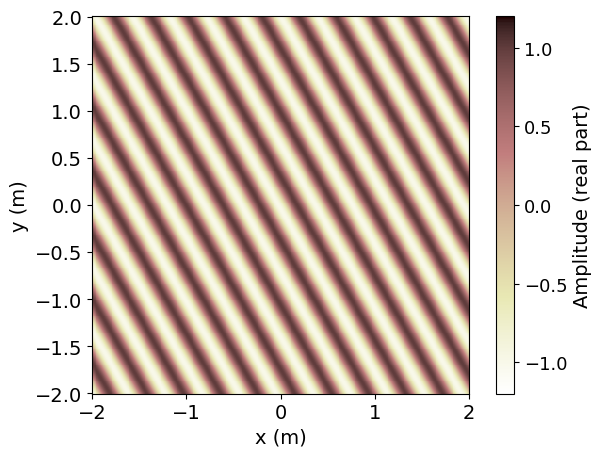

In [9]:
# Desired sound field ( and coefficents ) example

# Planewave
rvec = cent
phi = np.pi/6
theta = np.pi/2
des_coefs = planewave_coef(rvec, phi, theta, k, N, amp=1, cylind=True)

# Cyrindrical wave
# spos = np.array([1.0, 0.3])
# des_coefs = cylindricalwave_coef(cent[:2], spos, k, N, amp=10)

# Plot
sf_des = np.zeros((len(xticks),len(yticks)), dtype=complex)
for i, x in enumerate(xticks):
    for j, y in enumerate(yticks):
        # plane wave
        kvec = [k*np.cos(phi), k*np.sin(phi)]
        sf_des[j,i] = planewave([x-cent[0],y-cent[1],0], phi, theta, k)

        # cylindrical wave
        # sf_des[j,i] = cylindricalwave([x,y], [spos[0],spos[1]], k, amp=10)

fig, ax = plot_amp(xticks, yticks, sf_des)
plt.show()

In [10]:
# Calculate example distribution
G_opt = G[:, select]
G_regA = G[:, regAIdx]
G_regB = G[:, regBIdx]

lmd = np.linalg.norm(G_opt.conj().T @ W @ G_opt, ord=2) * 1e-3
drvOpt = np.squeeze( np.linalg.inv(G_opt.conj().T @ W @ G_opt + lmd*np.eye(L, dtype=complex)) @ G_opt.conj().T @ W @ des_coefs )

lmd = np.linalg.norm(G_regA.conj().T @ W @ G_regA, ord=2) * 1e-3
drvRegA = np.squeeze( np.linalg.inv(G_regA.conj().T @ W @ G_regA + lmd*np.eye(L, dtype=complex)) @ G_regA.conj().T @ W @ des_coefs )

lmd = np.linalg.norm(G_regB.conj().T @ W @ G_regB, ord=2) * 1e-3
drvRegB = np.squeeze( np.linalg.inv(G_regB.conj().T @ W @ G_regB + lmd*np.eye(L, dtype=complex)) @ G_regB.conj().T @ W @ des_coefs )

rvec = np.array([xticks.tolist()*len(yticks), np.repeat(yticks, len(xticks))]).T
sf_opt = np.zeros(X.shape, dtype=complex)
sf_regA = np.zeros(X.shape, dtype=complex)
sf_regB = np.zeros(X.shape, dtype=complex)
for i in range(L):
    svec = np.repeat([posSrc[select][i,:2]],len(rvec),axis=0)
    sf_opt += cylindricalwave(rvec, svec, k, amp=drvOpt[i]).reshape(X.shape)
    svec = np.repeat([posSrc[regAIdx][i,:2]],len(rvec),axis=0)
    sf_regA += cylindricalwave(rvec, svec, k, amp=drvRegA[i]).reshape(X.shape)
    svec = np.repeat([posSrc[regBIdx][i,:2]],len(rvec),axis=0)
    sf_regB += cylindricalwave(rvec, svec, k, amp=drvRegB[i]).reshape(X.shape)

In [11]:
# Transfer function for evaluation points
G_eval = np.zeros((len(posEval),len(posSrc)), dtype=complex)
for i in range(len(posSrc)):
    svec = np.repeat([posSrc[i][:2]],len(posEval),axis=0)
    G_eval[:, i] += cylindricalwave(posEval[:,:2], svec, k)

Average SDR
　Optimized:  34.51  (dB)
　Regular A:  29.88  (dB)
　Regular B:  3.96  (dB)


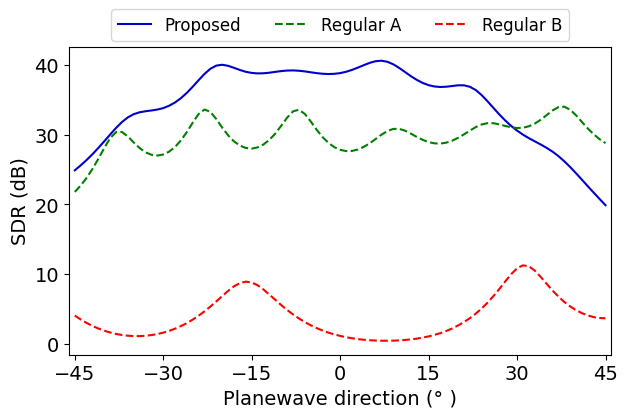

In [12]:
# Comparison
angles = np.arange(-45,46)*np.pi/180
sdrs = []

cnt = 0
theta = np.pi/2
for phi in angles:
    des = []
    for pos in posEval:
        des.append(planewave([pos[0]-cent[0], pos[1]-cent[1], 0], phi, theta, k))
    des = np.array(des)
    
    des_coefs = planewave_coef(rvec, phi, theta, k, N, amp=1, cylind=True)
    
    # drive signal
    lmd = np.linalg.norm(G_opt.conj().T @ W @ G_opt, ord=2) * 1e-3
    drvOpt = np.squeeze( np.linalg.inv(G_opt.conj().T @ W @ G_opt + lmd*np.eye(L, dtype=complex)) @ G_opt.conj().T @ W @ des_coefs )
      
    lmd = np.linalg.norm(G_regA.conj().T @ W @ G_regA, ord=2) * 1e-3
    drvRegA = np.squeeze( np.linalg.inv(G_regA.conj().T @ W @ G_regA + lmd*np.eye(L, dtype=complex)) @ G_regA.conj().T @ W @ des_coefs )
    
    lmd = np.linalg.norm(G_regB.conj().T @ W @ G_regB, ord=2) * 1e-3
    drvRegB = np.squeeze( np.linalg.inv(G_regB.conj().T @ W @ G_regB + lmd*np.eye(L, dtype=complex)) @ G_regB.conj().T @ W @ des_coefs )

    # SDR
    opt = G_eval[:,select]@drvOpt
    regA = G_eval[:,regAIdx]@drvRegA
    regB = G_eval[:,regBIdx]@drvRegB

    sdrs.append([SDR(des, opt), SDR(des, regA), SDR(des, regB)])
    
#     print(round(phi*180/np.pi,0), "° done.")

sdrs = np.array(sdrs)

# SDR
print("Average SDR")
print("　Optimized: ", round(sdrs[:,0].mean(), 2), " (dB)" )
print("　Regular A: ", round(sdrs[:,1].mean(), 2), " (dB)" )
print("　Regular B: ", round(sdrs[:,2].mean(), 2), " (dB)" )

# Plot
fig, ax = plt.subplots(figsize=(7,4))
# ax.set_title("SDR")
ax.plot(angles*180/np.pi, sdrs[:, 0], label="Proposed", c="mediumblue")
ax.plot(angles*180/np.pi, sdrs[:, 1], label="Regular A", linestyle="--", c="green")
ax.plot(angles*180/np.pi, sdrs[:, 2], label="Regular B", linestyle="--", c="red")
ax.set_xlabel("Planewave direction (° )")
ax.set_ylabel("SDR (dB)")
ax.set_xlim(-46,46)
ax.set_xticks(np.arange(-45,46,15))
# ax.set_ylim(15,38)
plt.legend(fontsize=12,loc="lower center", bbox_to_anchor=(0.5, 1.02), borderaxespad=0, ncol=3)
# plt.savefig("figs/SDR_1000Hz_freefield.png")
plt.show()

## Broadband

1 selected： 180
2 selected： 168
3 selected： 193
4 selected： 161
5 selected： 186
6 selected： 2
7 selected： 174
8 selected： 152
9 selected： 9
10 selected： 189


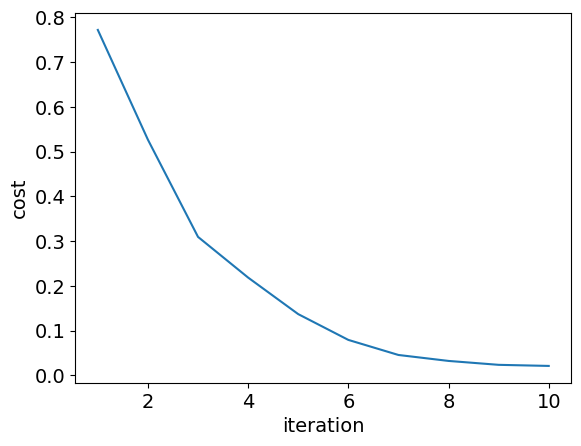

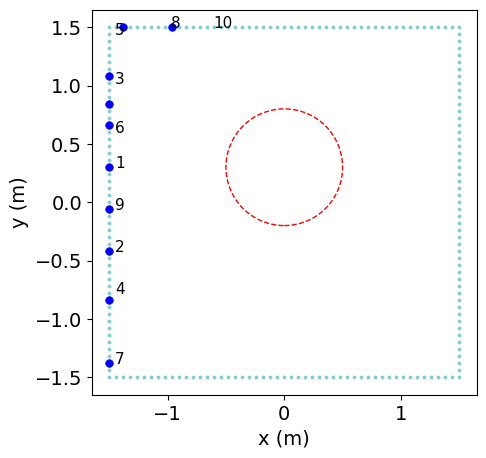

In [13]:
# Source optimization

# Gamma
gam = np.ones_like(f_target)
# gam = 1/f_target
# gam = -f_target+3000
gam = gam/sum(gam)

# Weight matrix list
W_list = []
for f in f_target:
    k = 2*np.pi*f/c
    w = np.zeros((2*N+1,2*N+1), dtype=complex)
    for n in range(-N, N+1):
        idx = n+N
        w[idx][idx] = np.pi * radi**2 * (special.jv(n, k*radi)**2 - special.jv(n+1, k*radi)*special.jv(n-1, k*radi))    
    W_list.append(w)

# Prior information
Sig = np.zeros((2*N+1,2*N+1), dtype=complex)
mu = np.zeros(2*N+1, dtype=complex)
for i in range(-N,N+1):
    for j in range(-N,N+1):
        if i != j:
            Sig[j+N,i+N] = 1j**(i-j)/(1j*(i-j))*(np.exp(1j*(i-j)*np.pi/4)-np.exp(-1j*(i-j)*np.pi/4))
        else:
            Sig[j+N,i+N] = np.pi/2

# Transfer function matrix list
G_l = np.zeros((len(f_target),2*N+1,len(posSrc)), dtype=complex)
for f in range(len(f_target)):
    k = 2*np.pi*f_target[f]/c
    for i in range(len(posSrc)):
        G_l[f, :, i] += cylindricalwave_coef(cent[:2], posSrc[i][:2], k, N)

# Regularization parameter list
lmds = []
for idx in range(len(W_list)):
    lmds.append(np.linalg.norm(G_l[idx].conj().T @ W_list[idx] @ G_l[idx], ord=2) * 1e-3)


# Greedy algorithm
bbselect = []
unselect = list(range(len(posSrc)))
costs = []

while len(bbselect) < L:
    minval = 1e6
    for i in unselect:
        E_J = 0
        for idx in range(len(W_list)):
            lmd = lmds[idx]
            E_J += cost_func(bbselect+[i], G_l[idx], Sig, mu, reg=lmd, W=W_list[idx]) * gam[idx]
        if E_J < minval:
            minval = E_J
            i_src = i

    bbselect.append(i_src)
    unselect.remove(i_src)

    print(len(bbselect),"selected：", i_src)
    costs.append(minval)


# Cost
plt.plot(np.arange(len(costs))+1,costs)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.show()

# Selected position
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(posSrc[:,0],posSrc[:,1],s=3,c='#83ccd2')
ax.scatter(posSrc[bbselect][:,0],posSrc[bbselect][:,1], marker='o', linewidth=0.5, s=30, c='blue')
for i,s in enumerate(posSrc[select]):
    pos = [s[0]+0.05,s[1]]
    plt.annotate(i+1,pos,fontsize=11)
obj_zone = patches.Circle(xy=cent, radius=radi, ec="red", fill=False, ls='dashed')
ax.add_patch(obj_zone)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.grid(False)
ax.set_aspect('equal')
plt.show()

In [14]:
# Regular position
# Regular A
regAIdx = np.linspace(126, 200, L, dtype=int)+17
regAIdx[regAIdx>=200] -= 200

# Regular B
regBIdx = np.linspace(0, 200, L, dtype=int)+np.ceil(100/len(select)).astype(int)
regBIdx[regBIdx>=200] -= 200

In [15]:
# Comparison (takes a few minutes)
t1 = time.time()

angles = np.arange(-45,46)*np.pi/180

sdrs = []
ave_sdr = []
for i_f, f in enumerate(fbin):
    # Wave number
    k = 2*np.pi*f/c
    
    # Weight matrix
    N = math.ceil(2*k*radi)
    if N < 5:
        N = 5
#     print("Truncation order : ", N)

    W = np.zeros((2*N+1,2*N+1), dtype=complex)
    for n in range(-N, N+1):
        idx = n+N
        W[idx][idx] = np.pi * radi**2 * (special.jv(n, k*radi)**2 - special.jv(n+1, k*radi)*special.jv(n-1, k*radi))    
    
    # Transfer function matrix
    G_b = np.zeros((2*N+1,len(posSrc)), dtype=complex)
    for i in range(len(posSrc)):
        G_b[:, i] += cylindricalwave_coef(cent[:2], posSrc[i][:2], k, N)
        
    G_eval_b = np.zeros((len(posEval),len(posSrc)), dtype=complex)
    for i in range(len(posSrc)):
        svec = np.repeat([posSrc[i][:2]],len(posEval),axis=0)
        G_eval_b[:, i] += cylindricalwave(posEval[:,:2], svec, k)

    # Prior information
    Sig = np.zeros((2*N+1,2*N+1), dtype=complex)
    mu = np.zeros(2*N+1, dtype=complex)
    for i in range(-N,N+1):
        for j in range(-N,N+1):
            if i != j:
                Sig[j+N,i+N] = 1j**(i-j)/(1j*(i-j))*(np.exp(1j*(i-j)*np.pi/4)-np.exp(-1j*(i-j)*np.pi/4)) - (mu[i+N])**2/(np.pi/2)
            else:
                Sig[j+N,i+N] = np.pi/2 - (mu[i+N])**2/(np.pi/2)
    
    # Greedy algorithm
    sel = []
    unselect = list(range(len(posSrc)))
    costs = [1e6]
    while len(sel) < L:
        minval = 1e6
        for i in unselect:
            J = cost_func(sel+[i], G_b, Sig, mu, W=W, reg=lmd)
            if J < minval:
                minval = J
                i_src = i
        sel.append(i_src)
        unselect.remove(i_src)
        costs.append(minval)
    
    G_opt = G_b[:, sel]
    G_bb= G_b[:, bbselect]
    G_regA = G_b[:, regAIdx]
    G_regB = G_b[:, regBIdx]
    
    # Average SDR
    for phi in angles:
        des = []
        for pos in posEval:
            des.append(planewave([pos[0]-cent[0],pos[1]-cent[1],0], phi, np.pi/2, k))
        des = np.array(des)

        des_coefs = planewave_coef(rvec, phi, np.pi/2, k, N, amp=1, cylind=True)
        
        # drive signal
        lmd = np.linalg.norm(G_opt.conj().T @ W @ G_opt, ord=2) * 1e-3
        drvOpt = np.squeeze( np.linalg.inv(G_opt.conj().T @ W @ G_opt + lmd*np.eye(L, dtype=complex)) @ G_opt.conj().T @ W @ des_coefs )
        
        lmd = np.linalg.norm(G_bb.conj().T @ W @ G_bb, ord=2) * 1e-3
        drvBB = np.squeeze( np.linalg.inv(G_bb.conj().T @ W @ G_bb + lmd*np.eye(L, dtype=complex)) @ G_bb.conj().T @ W @ des_coefs )

        lmd = np.linalg.norm(G_regA.conj().T @ W @ G_regA, ord=2) * 1e-3
        drvRegA = np.squeeze( np.linalg.inv(G_regA.conj().T @ W @ G_regA + lmd*np.eye(L, dtype=complex)) @ G_regA.conj().T @ W @ des_coefs )

        lmd = np.linalg.norm(G_regB.conj().T @ W @ G_regB, ord=2) * 1e-3
        drvRegB = np.squeeze( np.linalg.inv(G_regB.conj().T @ W @ G_regB + lmd*np.eye(L, dtype=complex)) @ G_regB.conj().T @ W @ des_coefs )

        # SDR
        opt = G_eval_b[:,sel]@drvOpt
        bb = G_eval_b[:,bbselect]@drvBB
        regA = G_eval_b[:,regAIdx]@drvRegA
        regB = G_eval_b[:,regBIdx]@drvRegB

        sdrs.append([SDR(des, opt), SDR(des, bb), SDR(des, regA), SDR(des, regB)])
        
#         print(f, " Hz, ", round(ang*180/np.pi,0), "° done.")
    print(f, "Hz done.") 
    ave_sdr.append(np.mean(sdrs[i_f*len(angles):(i_f+1)*len(angles)], axis=0))
    
sdrs = np.array(sdrs)
ave_sdr = np.array(ave_sdr)

t2 = time.time()
t2-t1

100 Hz done.
200 Hz done.
300 Hz done.
400 Hz done.
500 Hz done.
600 Hz done.
700 Hz done.
800 Hz done.
900 Hz done.
1000 Hz done.
1100 Hz done.
1200 Hz done.
1300 Hz done.
1400 Hz done.
1500 Hz done.
1600 Hz done.
1700 Hz done.
1800 Hz done.
1900 Hz done.
2000 Hz done.


217.4734230041504

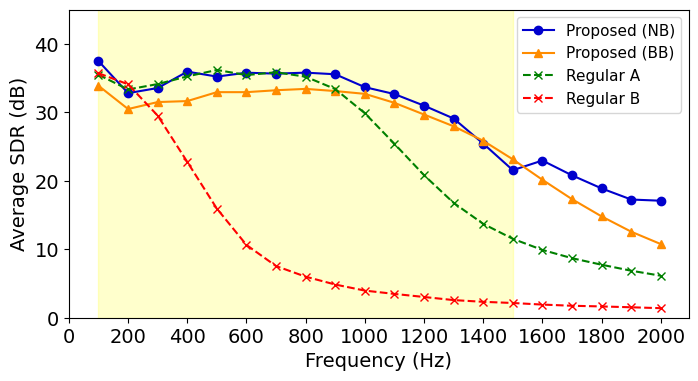

In [16]:
# Plot
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(fbin,ave_sdr[:,0],label="Proposed (NB)",marker="o",c="mediumblue",markeredgecolor="mediumblue",alpha=1)
ax.plot(fbin,ave_sdr[:,1],label="Proposed (BB)",linestyle="-",marker="^",c="darkorange",markeredgecolor="darkorange",alpha=1)
ax.plot(fbin,ave_sdr[:,2],label="Regular A",linestyle="--",marker="x",c="green",markeredgecolor="green",alpha=1)
ax.plot(fbin,ave_sdr[:,3],label="Regular B",linestyle="--",marker="x",c="red",markeredgecolor="red",alpha=1)
ax.fill_between([f_target[0],f_target[-1]],[80,80],color="yellow",alpha=0.2)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Average SDR (dB)")
ax.set_ylim([0,45])
ax.set_xticks(np.arange(0,2001,200))
ax.legend(fontsize=11)
# plt.savefig(f"figs/SDR_bb_freefield.pdf",bbox_inches='tight')
plt.show()

### 論文用figure作成コード

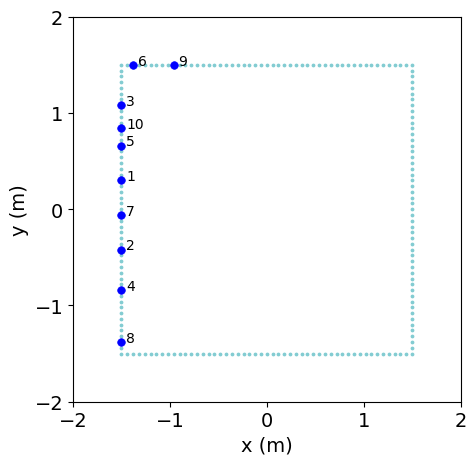

In [17]:
# Source position
plt.figure(figsize=(5,5))
plt.scatter(posSrc[:,0],posSrc[:,1],s=3,c='#83ccd2')
plt.scatter(posSrc[bbselect][:,0],posSrc[bbselect][:,1], marker='o', linewidth=0.5, s=30, c='blue')
for i,s in enumerate(posSrc[bbselect]):
    pos = [s[0]+0.05,s[1]]
    plt.annotate(i+1,pos,fontsize=10)
obj_zone = patches.Circle(xy=cent, radius=radi, ec="red", fill=False, ls='dashed')
plt.xticks(np.arange(x_lim[0],x_lim[-1]+0.01,1))
plt.yticks(np.arange(y_lim[0],y_lim[-1]+0.01,1))
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid(False)

plt.xticks(np.arange(-2.0,2.0+0.001,1))
plt.yticks(np.arange(-2,2+0.001,1))
# plt.savefig("figs/select_bb_freefield.pdf",bbox_inches='tight')
plt.show()

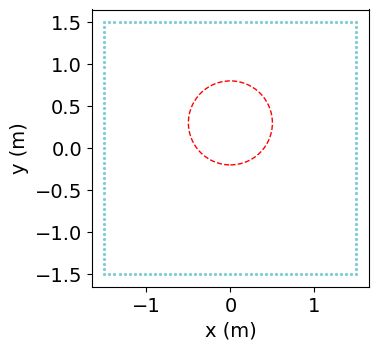

In [18]:
# Candidate position
fig, ax = plt.subplots(figsize=(4,4))
ax.grid(False)
ax.scatter(posSrc[:,0],posSrc[:,1], s=9, linewidth=0.8, marker='.', c="#83ccd2", label="src")
# ax.scatter(optPos[:,0],optPos[:,1], s=20, linewidth=0.8, marker='o', c="blue", label="src")
ax.set_aspect('equal')
obj_zone = patches.Circle(xy=cent, radius=radi, ec="red", fill=False, ls='dashed')
ax.add_patch(obj_zone)

ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

plt.tight_layout()

# plt.savefig("figs/freefield.pdf")
plt.show()

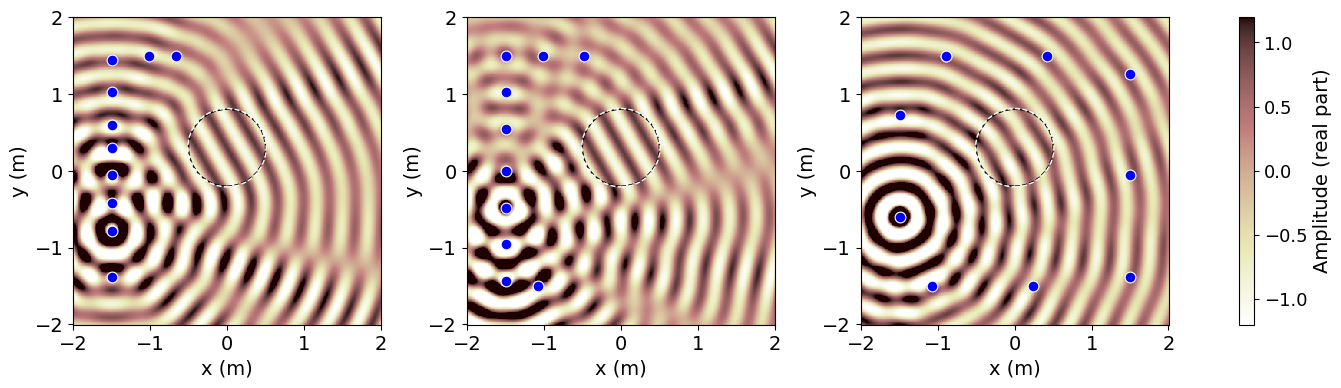

In [19]:
# Amplitude distribution
fig, ax = plt.subplots(1,3,figsize=(18,4))

syn = [sf_opt, sf_regA, sf_regB]
src = [posSrc[select,:2], posSrc[regAIdx,:2], posSrc[regBIdx,:2]]
for n in range(3):
    quadmesh = ax[n].pcolormesh(X, Y, syn[n].real,cmap="pink_r")
    ax[n].set_aspect('equal')
    quadmesh.set_clim(vmin=-1.2, vmax=1.2)
    ax[n].grid(False)

    ax[n].set_xlabel("x (m)")
    ax[n].set_ylabel("y (m)")
    
    ax[n].scatter(src[n][:,0], src[n][:,1], s=60, linewidth=0.8, marker='o', c="blue", label="Source", edgecolor="white")
    
    obj_zone = patches.Circle(xy=cent, radius=radi, ec='#000000', fill=False, ls='dashed')
    ax[n].add_patch(obj_zone)
    obj_zone2 = patches.Circle(xy=cent, radius=radi+0.01, ec='#ffffff', fill=False, ls='dashed')
    ax[n].add_patch(obj_zone2)

# plt.tight_layout()
cbar = fig.colorbar(quadmesh, ax=ax, ticks=np.arange(-1,1+0.001,0.5))
cbar.set_label("Amplitude (real part)")
cbar.ax.tick_params(labelsize=13)
# plt.savefig("figs/amp_freefield.pdf")
plt.show()

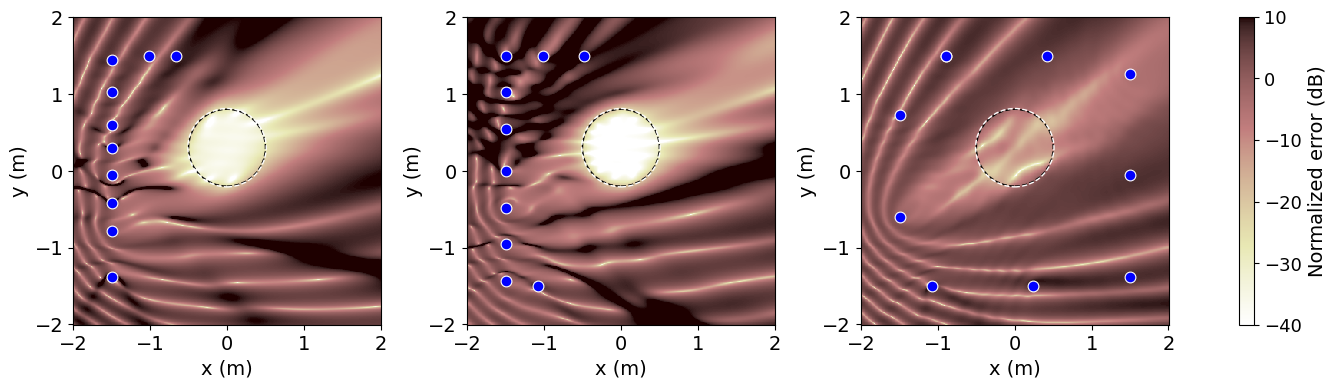

In [20]:
# Normalized error distribution
fig, ax = plt.subplots(1,3,figsize=(18,4))

syn = [sf_opt, sf_regA, sf_regB]
src = [posSrc[select,:2], posSrc[regAIdx,:2], posSrc[regBIdx,:2]]
for n in range(3):
    ne = 10 * np.log10( abs(sf_des-syn[n])**2/abs(syn[n])**2 )
    quadmesh = ax[n].pcolormesh(X,Y, ne.real,cmap="pink_r")
    ax[n].set_aspect('equal')
    quadmesh.set_clim(vmin=-40,vmax=10)
    ax[n].grid(False)

    ax[n].set_xlabel("x (m)")
    ax[n].set_ylabel("y (m)")
    
    ax[n].scatter(src[n][:,0], src[n][:,1], s=60, linewidth=0.8, marker='o', c="blue", label="Source", edgecolor="white")
    
    obj_zone = patches.Circle(xy=cent, radius=radi, ec='#000000', fill=False, ls='dashed')
    ax[n].add_patch(obj_zone)
    obj_zone2 = patches.Circle(xy=cent, radius=radi+0.01, ec='#ffffff', fill=False, ls='dashed')
    ax[n].add_patch(obj_zone2)

# plt.tight_layout()
cbar = fig.colorbar(quadmesh, ax=ax)
cbar.set_label("Normalized error (dB)")
cbar.ax.tick_params(labelsize=13)
# plt.savefig("figs/ne_freefield.pdf")
plt.show()

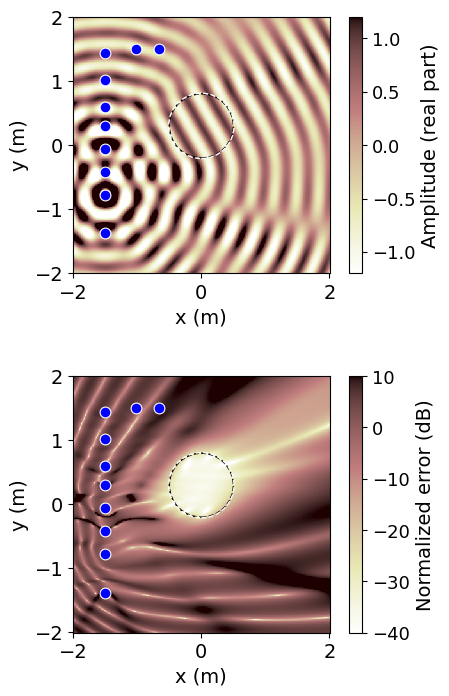

In [21]:
# Plot distribution
fig, ax = plt.subplots(2,1,figsize=(5,8))
syn = sf_opt
src = posSrc[select,:2]

quadmesh = ax[0].pcolormesh(X,Y, syn.real,cmap="pink_r")
ax[0].set_aspect('equal')
quadmesh.set_clim(vmin=-1.2, vmax=1.2)
ax[0].grid(False)

ax[0].set_xlabel("x (m)")
ax[0].set_ylabel("y (m)")

ax[0].scatter(src[:,0], src[:,1], s=60, linewidth=0.8, marker='o', c="blue", label="Source", edgecolor="white")

obj_zone = patches.Circle(xy=cent, radius=radi, ec='#000000', fill=False, ls='dashed')
ax[0].add_patch(obj_zone)
obj_zone2 = patches.Circle(xy=cent, radius=radi+0.01, ec='#ffffff', fill=False, ls='dashed')
ax[0].add_patch(obj_zone2)

cbar = fig.colorbar(quadmesh, ax=ax[0], ticks=np.arange(-1,1+0.001,0.5))
cbar.set_label("Amplitude (real part)")
cbar.ax.tick_params(labelsize=13)


ne = 10 * np.log10( abs(sf_des-syn)**2/abs(syn)**2 )
quadmesh = ax[1].pcolormesh(X,Y, ne.real,cmap="pink_r")
ax[1].set_aspect('equal')
quadmesh.set_clim(vmin=-40,vmax=10)
ax[1].grid(False)

ax[1].set_xlabel("x (m)")
ax[1].set_ylabel("y (m)")

ax[1].scatter(src[:,0], src[:,1], s=60, linewidth=0.8, marker='o', c="blue", label="Source", edgecolor="white")

obj_zone = patches.Circle(xy=cent, radius=radi, ec='#000000', fill=False, ls='dashed')
ax[1].add_patch(obj_zone)
obj_zone2 = patches.Circle(xy=cent, radius=radi+0.01, ec='#ffffff', fill=False, ls='dashed')
ax[1].add_patch(obj_zone2)

cbar = fig.colorbar(quadmesh, ax=ax[1])
cbar.set_label("Normalized error (dB)")
cbar.ax.tick_params(labelsize=13)

plt.subplots_adjust(wspace=0.0, hspace=0.4)

# plt.savefig("figs/regA_0_freefield.pdf")
plt.show()